# UnderspecificationAnalysis User Guide
The UnderspecificationAnalysis package contains methods that help to diagnose and illustrate potential model underspecification. This notebook demonstrates how to use this package along side a breast cancer subtyping dataset from METABRIC.  

In [1]:
%load_ext autoreload
%autoreload 2

## Imports
Importing necessary libraries for processing the sample dataset and importing the UnderspecificationAnalysis class.

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [34]:
#@title Includes and Dependencies
from IPython.display import display, Markdown, Latex
try:
    import pump
    from pump.underspecification import PUMP, GenerateByKMeans
    from pump.transformers import ClassFocusTransformer
    print('Imported preinstalled pump')
except:
    import sys
    sys.path.insert(0,"../..") 
    import pump
    from pump.underspecification import PUMP, GenerateByKMeans
    from pump.transformers import ClassFocusTransformer
    print('Imported ../.. pump')

Imported preinstalled pump


In [7]:
import pandas as pd

## Data Processing
Loading and pre-processing the lung cancer diagnosis dataset from TCGA. The labels were manually added in prior to loading into this notebook, so the method to extract the labels is not traditional. We also want to make sure all entries are valid, so we need the complete dataset Xy along with the separate X and y for later use.

In [11]:
import pandas as pd
url='https://drive.google.com/file/d/1J5lnmAVUbMXQuODLdFF19Bl_YAqPzAXj/view?usp=share_link'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url,sep='\t')
#df = pd.read_csv('brca_metabric_clinical_data.tsv',sep='\t')
df = df.loc[df['Pam50 + Claudin-low subtype']!='NC']
df.set_index('Sample ID',inplace=True)

In [12]:
urls=[
    "https://drive.google.com/file/d/10QpYL1ZWW7ljqsCSeXKX9ZO30B73uHuM/view?usp=share_link",
    "https://drive.google.com/file/d/1JE0KkTx9mSSrdfNwISiEXX2aLSq-GmrJ/view?usp=share_link",
    "https://drive.google.com/file/d/18tgo-o_-qPCVSjuBEPVrbphrA-Hbi4D9/view?usp=share_link",
    "https://drive.google.com/file/d/1SYa5E5UU6a8H6dY4yrk3QDfHKRQOLigm/view?usp=share_link",
    "https://drive.google.com/file/d/1627jeYR6m1m33qnFxvgeAezp91GiR6PM/view?usp=share_link"
    "https://drive.google.com/file/d/1ydv5JLmtZ-CjZuE0raaSITwOwvN5Hzql/view?usp=share_link",
    "https://drive.google.com/file/d/1aKkviqXT2-zDCvEFCwut_ixE1w5E54iO/view?usp=share_link",
    "https://drive.google.com/file/d/1lQvm8dO6QkM8Rtl3q54YLV8rgVyDuwQu/view?usp=share_link",
    "https://drive.google.com/file/d/15EbQti2sF-TzD606fkUCw4B8gII1oB_p/view?usp=share_link",
    "https://drive.google.com/file/d/1XPu2BylAMoQP7olPDCQX6Y9jBbXb5g-S/view?usp=share_link",
    "https://drive.google.com/file/d/1ZeBGGn3YqfSqweWQqcW1gKXBj2kY_ELQ/view?usp=share_link",
    "https://drive.google.com/file/d/1J_dHQOsegjmN_nylscCVSHCZeyZWFLoi/view?usp=share_link",
    "https://drive.google.com/file/d/1LE4F7OIJrRJIsavvZKQVMt41Q2Vs_5WY/view?usp=share_link",
    "https://drive.google.com/file/d/12unnzNfBqQ-WB1vPVD-fM_LRPd8uhH7_/view?usp=share_link",
    "https://drive.google.com/file/d/1ke2hviV3WY81X-WoZg2r1TCOXehpgo-l/view?usp=share_link",
    "https://drive.google.com/file/d/1iDcHtSMJY2e3w7oufEh1yCltWp7sbAr3/view?usp=share_link",
    "https://drive.google.com/file/d/1AjMMdh_5UIojAoTUBL9KF3JoCpncLU_7/view?usp=share_link",
    "https://drive.google.com/file/d/1V8YXJstjrQv6p7zTwzuFU42V8kL6utfT/view?usp=share_link",
    "https://drive.google.com/file/d/1NdWS49_No9unD9Rm7bWr8JVJ14NGSgbO/view?usp=share_link",
    "https://drive.google.com/file/d/1llGTAWM8vuirS_TX-Hvv4mq7snYrJvAl/view?usp=share_link",
    "https://drive.google.com/file/d/1xsL-fEq0PXw_B_jEAVkf4HkMk-m0BA5f/view?usp=share_link",
    "https://drive.google.com/file/d/1zm-IhmDpziYwM8ceh2daMQkatSmE2Xv7/view?usp=share_link"
]

In [13]:
Xs = []
columns = None
for url in urls:
    url='https://drive.google.com/uc?id=' + url.split('/')[-2]
    if columns is None:
        X = pd.read_csv(url)
        columns = X.columns
    else:
        X = pd.read_csv(url,header=None)
        X.columns = columns
    X.set_index('Sample ID',inplace=True)
    Xs.append(X)

X = pd.concat(Xs, axis=0)
X.head()

,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AACSP1,AADAC,AADACL2,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
Sample ID,,,,,,,,,,,,,,,,,,,,,
MB-0362,0.121975,0.215056,0.137268,0.319299,0.299318,0.379480,0.412660,0.361855,0.101269,0.172184,...,0.221594,0.299784,0.362357,0.225769,0.367554,0.132938,0.328175,0.573906,0.539070,0.147249
MB-0346,0.192559,0.042307,0.204485,0.103171,0.315292,0.391824,0.544226,0.372350,0.087123,0.164404,...,0.156303,0.516268,0.489675,0.363120,0.457905,0.155936,0.121523,0.483270,0.411438,0.224434
MB-0386,0.129016,0.302035,0.104212,0.478857,0.307694,0.265761,0.191160,0.214396,0.124491,0.135946,...,0.167134,0.210737,0.420390,0.164456,0.268026,0.169930,0.358189,0.616131,0.515510,0.124535
MB-0574,0.186569,0.204583,0.084922,0.155657,0.259502,0.225779,0.276242,0.363504,0.156255,0.174428,...,0.177223,0.211609,0.669651,0.530200,0.548744,0.054719,0.364991,0.480279,0.564949,0.158037
MB-0185,0.110777,0.337835,0.133802,0.265908,0.555257,0.349347,0.222268,0.381949,0.058114,0.111793,...,0.382424,0.450318,0.644640,0.280082,0.305045,0.135671,0.259829,0.531486,0.503557,0.165486


In [14]:
y = df['Pam50 + Claudin-low subtype']
Xy = X.join(y).dropna()
X = Xy.drop(['Pam50 + Claudin-low subtype'], axis=1)
y = Xy['Pam50 + Claudin-low subtype']
Xy

,A1CF,A2M,A2ML1,A4GALT,A4GNT,AAAS,AACS,AACSP1,AADAC,AADACL2,...,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3,Pam50 + Claudin-low subtype
Sample ID,,,,,,,,,,,,,,,,,,,,,
MB-0362,0.121975,0.215056,0.137268,0.319299,0.299318,0.379480,0.412660,0.361855,0.101269,0.172184,...,0.299784,0.362357,0.225769,0.367554,0.132938,0.328175,0.573906,0.539070,0.147249,LumA
MB-0346,0.192559,0.042307,0.204485,0.103171,0.315292,0.391824,0.544226,0.372350,0.087123,0.164404,...,0.516268,0.489675,0.363120,0.457905,0.155936,0.121523,0.483270,0.411438,0.224434,Her2
MB-0386,0.129016,0.302035,0.104212,0.478857,0.307694,0.265761,0.191160,0.214396,0.124491,0.135946,...,0.210737,0.420390,0.164456,0.268026,0.169930,0.358189,0.616131,0.515510,0.124535,LumA
MB-0574,0.186569,0.204583,0.084922,0.155657,0.259502,0.225779,0.276242,0.363504,0.156255,0.174428,...,0.211609,0.669651,0.530200,0.548744,0.054719,0.364991,0.480279,0.564949,0.158037,LumA
MB-0185,0.110777,0.337835,0.133802,0.265908,0.555257,0.349347,0.222268,0.381949,0.058114,0.111793,...,0.450318,0.644640,0.280082,0.305045,0.135671,0.259829,0.531486,0.503557,0.165486,LumB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MB-5453,0.123899,0.758462,0.111082,0.388901,0.469854,0.265111,0.292791,0.374861,0.112473,0.143079,...,0.152024,0.339924,0.262486,0.398045,0.006885,0.645722,0.706595,0.673984,0.413533,Normal
MB-5471,0.086833,0.383323,0.148131,0.455040,0.424542,0.264008,0.323045,0.466199,0.133736,0.111767,...,0.336048,0.578365,0.360607,0.409253,0.134941,0.489436,0.784043,0.524229,0.346266,LumA
MB-5127,0.161060,0.322914,0.089267,0.249016,0.506120,0.347471,0.262816,0.313490,0.136973,0.124235,...,0.125430,0.612635,0.566129,0.497388,0.125114,0.708827,0.548029,0.537391,0.362411,LumB


## Data Analysis
There are many ways in which to prepare data. Here we showcase one such method that may be customized.

In [15]:
focus_transformer = ClassFocusTransformer('Her2')
Xf,yf = focus_transformer.fit(X,y).transform(X,y)

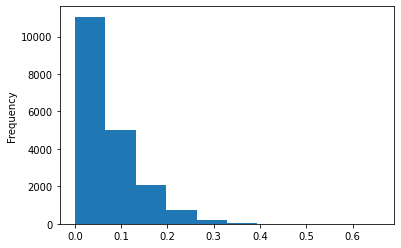

In [16]:
Xf.min().plot.hist();

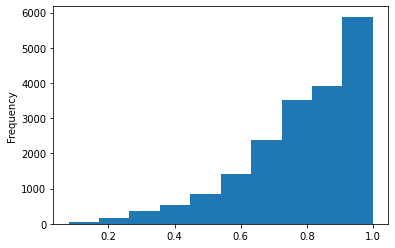

In [17]:
Xf.max().plot.hist();

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(Xf)
Xf_pca = pca.transform(Xf)
Xf_pca = pd.DataFrame(Xf_pca,columns=['PC1','PC2'])
Xf_pca.index = Xf.index
Xf_pca.head()

,PC1,PC2
Sample ID,,
MB-0346,-2.685653,-4.355782
MB-0506,-3.791191,0.141527
MB-0249,-6.314711,0.257707
MB-0660,-4.099091,0.075839
MB-0653,-4.160789,-3.939251


In [19]:
import altair as alt

source = Xf_pca.reset_index()

alt.Chart(source).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    tooltip=['Sample ID']
).interactive()

alt.Chart(...)

In [20]:
Xf_pca

,PC1,PC2
Sample ID,,
MB-0346,-2.685653,-4.355782
MB-0506,-3.791191,0.141527
MB-0249,-6.314711,0.257707
MB-0660,-4.099091,0.075839
MB-0653,-4.160789,-3.939251
...,...,...
MB-0418,1.718172,-5.493099
MB-0652,-5.159170,0.001994
MB-0188,-4.721259,0.228729


In [23]:
generator = GenerateByKMeans()
generator.fit(Xf_pca,yf)

In [24]:
source['Cluster'] = (generator.cluster_labels()+1)

In [25]:
import altair as alt

alt.Chart(source).mark_circle(size=60).encode(
    x='PC1',
    y='PC2',
    color='Cluster:N',
    tooltip=['Sample ID']
).interactive()

alt.Chart(...)

## Initializing PUMP
Since PUMP is a Python library, this is a typical way to initialize the class. We set the general data directory to be 'data/'

In [37]:
pump = PUMP(X, y, output_dir='data')

Running PCA Analysis ...
Running Kmeans Analysis ...
Plotting Cluster Analysis ...
-----[ COMPLETE ]-----
Check /data/her2_analysis for the results.


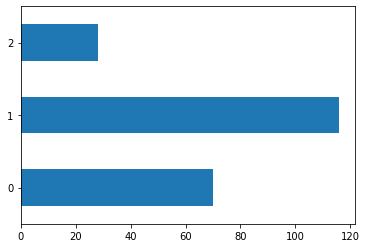

In [39]:
analysis_results = pump.analyze_dataset("her2_analysis", transformers=[ClassFocusTransformer("Her2")], num_clusters=3)

## Shifted Stress Testing
Knowing that we prefer the 3 clusters on HER2, we want to create shifted datasets around HER2 to stress test models. We choose to have 50 shifted sets per cluster and an 80-20 train-test split (70-10 for train-val). The datasets can be viewed in 'data/indices'.

In [77]:
pump.create_shifted_datasets(analysis_results['kmeans'],
                             num_clusters=3,
                             shift_type='clustering',
                             split_ratio=[0.7,0.1,0.2],
                             cluster_focus='Her2',
                             subdirectory='indices',
                             num_shifted_sets=50
)

Creating shifted sets ...
Writing out sets ...
-----[ COMPLETE ]-----
Check /data/indices for the results.


## Performance Evaluation
PUMP provides a variety of options in terms of evaluating performances on shifted datasets. Currently, PUMP supports the following models:
* SVM: (Linear) Supoprt Vector Machines
* RF: Random Forest
* MLP: Neural Network (Multi-Layer Perceptron)

For the purpose of this notebook, we will train on Random Forest with random states 0-2. The performance metrics can be viewed in 'data/results/'.

In [53]:
pump.evaluate_shifted_sets(X, y, subdirectory='results', models=['rf'], random_states=[0, 1, 2])

Evaluating models ...
    Evaluating: data/indices\0,False/index_df_0.csv
    Evaluating: data/indices\0,False/index_df_1.csv
    Evaluating: data/indices\0,False/index_df_10.csv
    Evaluating: data/indices\0,False/index_df_11.csv
    Evaluating: data/indices\0,False/index_df_12.csv
    Evaluating: data/indices\0,False/index_df_13.csv
    Evaluating: data/indices\0,False/index_df_14.csv
    Evaluating: data/indices\0,False/index_df_15.csv
    Evaluating: data/indices\0,False/index_df_16.csv
    Evaluating: data/indices\0,False/index_df_17.csv
    Evaluating: data/indices\0,False/index_df_18.csv
    Evaluating: data/indices\0,False/index_df_19.csv
    Evaluating: data/indices\0,False/index_df_2.csv
    Evaluating: data/indices\0,False/index_df_20.csv
    Evaluating: data/indices\0,False/index_df_21.csv
    Evaluating: data/indices\0,False/index_df_22.csv
    Evaluating: data/indices\0,False/index_df_23.csv
    Evaluating: data/indices\0,False/index_df_24.csv
    Evaluating: data/indice

## Discrepancy Graphs
To better analyze the results, let's visualize the Random Forest performances on the shifted datasets. The graphs can be viewed in 'data/results/'.

In [54]:
pump.plot_shifted_results(filename='rf_results.csv', subdirectory='results')

## Model Selection
Finally, we will select the top 10 models on the HER2 subtype. Note: a DataFrame is returned instead of written out. 

In [55]:
pump.select_top_models(filename='rf_results.csv', subdirectory='results', num_models=10, class_filter='Her2')

class  rep  seed    cluster  avg f1-score - f1-score (unshifted)
cluster   rep                                                                 
indices\0 1    Her2    1    20  indices\0                        -4.107143e-01
          0    Her2    0    17  indices\0                        -4.022989e-01
indices\2 1    Her2    1    24  indices\2                        -5.039508e-02
indices\0 2    Her2    2    19  indices\0                        -3.536858e-02
indices\2 2    Her2    2     4  indices\2                        -2.126126e-02
indices\1 1    Her2    1    20  indices\1                         1.110223e-16
          0    Her2    0    20  indices\1                         3.616201e-03
indices\2 0    Her2    0    20  indices\2                         6.004141e-03
indices\1 2    Her2    2    33  indices\1                         2.624427e-02